#### Filenames

Galaxy catalogues from running the LensPop code are stored here:
- /mnt/users/hollowayp/LensPop_Versions/LensPop_Catalogue_{Orig/DP0/True}_Config.csv 

These (only one catalogue for LSST at the moment) are then converted to paltas-esque catalogues, stored here, which contains details of the individual galaxies:
- /mnt/zfsusers/hollowayp/paltas/datasets/LensPop_databases/LensPop_LSST_Paltas_Catalogue_0.csv

A further file, of population-level data (mean/std), for training paltas is saved here:
- /mnt/zfsusers/hollowayp/sim-pipeline/paltas_databases/Lenspop_{survey}_config_db.csv

These are used to update 3 template config files:
- f'{folder_path}/config_{survey}.py',
- f'{folder_path}/config_{survey}_no_RSP.py',
- f'{folder_path}/config_{survey}_no_subtr.py',

to produce:

- f'{folder_path}/config_{survey}_Lenspop.py'
- f'{folder_path}/config_{survey}_Lenspop_no_RSP.py'
- f'{folder_path}/config_{survey}_Lenspop_no_subtr.py'

In [2]:
def lenspop_output_catalogue(version):
    output_file = f'/mnt/users/hollowayp/LensPop_Versions/LensPop_Catalogue_{version}_Config.csv'
    print(f'Saving to {output_file}')
    return output_file

def individual_galaxy_catalogue(survey):
    output_file = f'/mnt/zfsusers/hollowayp/paltas/datasets/LensPop_databases/LensPop_{survey}_Paltas_Catalogue_0.csv'
    return output_file

def population_galaxy_catalogue(survey):
    assert survey in ['LSST','Euclid'] #Needs to be 'Euclid' not 'Euclid_VIS' otherwise will save to wrong config file
    output_file = f'/mnt/zfsusers/hollowayp/sim-pipeline/paltas_databases/Lenspop_{survey}_config_db.csv'
    print(f'Saving to {output_file}')
    return output_file

# Code

In [2]:
from scipy.stats import halfnorm,norm
from seaborn import pairplot,kdeplot
import matplotlib.pyplot as pl
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import glob
import json
import sys
import os
sys.path.append('/mnt/zfsusers/hollowayp/paltas/')
sys.path.append('/mnt/zfsusers/hollowayp/paltas/notebooks/')
from Ellipticities_Translation import EllipticitiesTranslation
from Load_LensPop_LSST_db import db_LensPop_LSST
from plot_image_collage import plot_collage
from load_h5_file import load_h5_file
from generate_config_file_functions import generate_config_file,generate_config_file_based_on_database

data = {}
filenames_dict = {'Orig':glob.glob('/mnt/users/hollowayp/LensPop_Versions/LensPop/LensStats/LSST_lsst_Lens_stats_*.pkl'),
            'DP0':glob.glob('/mnt/users/hollowayp/LensPop_Versions//LensPop_DP0_Config/LensStats/LSST_lsst_Lens_stats_*.pkl'),
            'True':glob.glob('/mnt/users/hollowayp/LensPop_Versions/LensPop_LSST_True_Config/LensStats/LSST_lsst_Lens_stats_*.pkl')}

for config_type in filenames_dict.keys():
    data[config_type] = []
    for filename_i in filenames_dict[config_type]:
        with open(filename_i,'rb') as f:
            data[config_type].append(pickle.load(f,encoding='latin1'))

In [4]:
def get_nested(data, args_list):
    if len(args_list)>0 and data:
        element  = args_list[0]
        if element:
            value = data.get(element)
            return value if len(args_list) == 1 else get_nested(value, args_list[1:])

LensPop_output_dict = {'Orig':{},'DP0':{},'True':{}}
key_dict = {'zl':'',
            'zs':[1],
            'seeing':['LSSTa','i_SDSS'],
            'sigl':'',
            'xs':[1],
            'ps':[1],
            'rs':[1],
            'pf':['LSSTa',1], #All of these are true
            'rl':['i_SDSS'],
            'resolved':['LSSTa',1,'i_SDSS'], #Not all of these are true. This is the mu*R_source > seeing constraint.
            'lens?':'', #All of these are true
            'mag':[1],
            'ys':[1],
            'qs':[1],
            'b':[1],
            'ml':['i_SDSS'],
            'msrc':[1,'i_SDSS'],
            'SN':['LSSTa',1,'i_SDSS'],
            'ms':[1,'i_SDSS'],
            'ql':''
    }

N_dict = {'Orig':0,'DP0':0,'True':0}
for LensPop_config in ['Orig','DP0','True']:
    for file_indx in range(len(data[LensPop_config])):
        data_i = data[LensPop_config][file_indx][1]
        for d_i in data_i.keys():
            N_dict[LensPop_config]+=1
            if data_i[d_i]['pf']['LSSTa'][1]==False: continue #Rejecting systems which fail LSSTa cuts
            for k_i in key_dict:
                try:
                    if key_dict[k_i]=='': LensPop_output_dict[LensPop_config][k_i].append(data_i[d_i][k_i])
                    else: LensPop_output_dict[LensPop_config][k_i].append(get_nested(data_i[d_i][k_i],key_dict[k_i]))
                except:
                    if key_dict[k_i]=='': LensPop_output_dict[LensPop_config][k_i] = [data_i[d_i][k_i]]
                    else: LensPop_output_dict[LensPop_config][k_i] = [get_nested(data_i[d_i][k_i],key_dict[k_i])]
    db_i = pd.DataFrame(LensPop_output_dict[LensPop_config])
    #Selecting maximum SNR:
    db_i['SN'] = np.array([np.max(db_i['SN'][elem]) for elem in range(len(db_i))])
    #Only selecting resolved systems with SNR_i>20:
    db_i = db_i[(db_i['SN']>=20)&(db_i['resolved']==True)].reset_index()
    LensPop_output_dict[LensPop_config]= db_i.copy()
    LensPop_output_dict[LensPop_config]['Config']=LensPop_config

pairplot_db = pd.concat([LensPop_output_dict[elem] for elem in ['Orig','DP0','True']],ignore_index=True).reset_index()

for LensPop_config in ['Orig','DP0','True']:
    LensPop_output_dict[LensPop_config] = LensPop_output_dict[LensPop_config]

print(N_dict)

{'Orig': 2832, 'DP0': 1658, 'True': 1806}


In [5]:
#Dictionary to go from the LensPop-Code generated names to the names of the properties in the saved
#LensPop .txt files.
column_name_dict = {'zl':'zL','zs':'zS','sigl':'sig_v',
                    'rs':'Re_source','rl':'Re_lens','qs':'q_source_flat','b':'tE','ml':'i_lens',
                    'ms':'i_source','ql':'q_lens_flat'}
def rand_position_angle(N_obj):
    np.random.seed(1)
    return 180*np.random.random(size=N_obj)

for k_i in LensPop_output_dict.keys(): #Introducing a random PA offset so PA_lens isn't defined as zero
    rand_position_angle_offset = rand_position_angle(len(LensPop_output_dict[k_i]))
    LensPop_output_dict[k_i]['PA_source'] =  LensPop_output_dict[k_i]['ps']+rand_position_angle_offset
    LensPop_output_dict[k_i]['PA_source']=LensPop_output_dict[k_i]['PA_source']%180 #Max value must be 180 as it was before
    LensPop_output_dict[k_i]['PA_lens'] = rand_position_angle_offset
    LensPop_output_dict[k_i]['PA_lens'] = LensPop_output_dict[k_i]['PA_lens']%180 #Max value must be 180 as it was before

for k_i in LensPop_output_dict.keys():
    LensPop_output_dict_e1e2_source = EllipticitiesTranslation(LensPop_output_dict[k_i]['PA_source']*(2*np.pi/360),
                                                                LensPop_output_dict[k_i]['qs'])
    LensPop_output_dict[k_i]['e1_source'] = LensPop_output_dict_e1e2_source[0]
    LensPop_output_dict[k_i]['e2_source'] = LensPop_output_dict_e1e2_source[1]
    LensPop_output_dict[k_i]=LensPop_output_dict[k_i].rename(column_name_dict,axis=1)

np.random.seed(1)

for k_i in LensPop_output_dict.keys():
    #PA_LensPop_New = generate_LensPop_PA(LensPop_output_dict[k_i])
    #LensPop_output_dict[k_i]['PA_lens'] = 0 #x-axis and Semi-major axis of lens are aligned (according to LensPop Paper) - now updated above to include random offset
    db_LensPop_e1,db_LensPop_e2 = EllipticitiesTranslation(LensPop_output_dict[k_i]['PA_lens'],
                                                           LensPop_output_dict[k_i]['q_lens_flat'])
    LensPop_output_dict[k_i]['e1_lens'] = db_LensPop_e1
    LensPop_output_dict[k_i]['e2_lens'] = db_LensPop_e2

LensPop_output_dict['Orig'].to_csv(lenspop_output_catalogue('Orig'))
LensPop_output_dict['DP0'].to_csv(lenspop_output_catalogue('DP0'))
LensPop_output_dict['True'].to_csv(lenspop_output_catalogue('True'))

Saving to /mnt/users/hollowayp/LensPop_Versions/LensPop_Catalogue_Orig_Config.csv
Saving to /mnt/users/hollowayp/LensPop_Versions/LensPop_Catalogue_DP0_Config.csv
Saving to /mnt/users/hollowayp/LensPop_Versions/LensPop_Catalogue_True_Config.csv


In [46]:
LensPop_output_dict['DP0']['PA_lens'].min()

0.020587467122079595

### Corner Plot Comparison of LSST Versions

In [ ]:
corner_dict = {'corner':True,'hue':'Config','kind':'scatter'}
columns_to_plot = ['$z_L$','$z_S$','$\sigma_v$','$R_{lens}$','$\mu$','$i_{lens}$','$i_{source}$','$\\theta_E$','Config']
pairplot_db = pairplot_db.rename({'zl':'$z_L$','zs':'$z_S$','sigl':'$\sigma_v$',
                                  'rl':'$R_{lens}$','mag':'$\mu$','b':'$\\theta_E$',
                                  'ms':'$i_{source}$','ml':'$i_{lens}$'},axis=1)
g = pairplot(pairplot_db[columns_to_plot],**corner_dict,diag_kind="kde", plot_kws={'alpha': 0.5})
pl.setp(g.legend.get_title(), fontsize='25') # for legend title
pl.setp(g.legend.get_texts(), fontsize='22') # for legend text
g.tick_params(labelsize=15)
g.tight_layout()
for ax_x in range(g.axes.shape[0]):
    for ax_y in range(g.axes.shape[1]):
        try:
            xlabel_i = g.axes[ax_x,ax_y].get_xlabel()
            ylabel_i =  g.axes[ax_x,ax_y].get_ylabel()
        except: continue
        g.axes[ax_x,ax_y].set_xlabel(xlabel_i,fontsize=15)
        g.axes[ax_x,ax_y].set_ylabel(ylabel_i,fontsize=15)
pl.show()

### Finding the noise level in RSP images, to exclude cutouts with galaxies in the centre 

In [6]:
glob.glob('/mnt/users/hollowayp/paltas/RSP_Coadd_Files_100000/*image*.h5')[0]

'/mnt/users/hollowayp/paltas/RSP_Coadd_Files_100000/85_image_data.h5'

  0%|          | 0/1 [00:00<?, ?it/s]

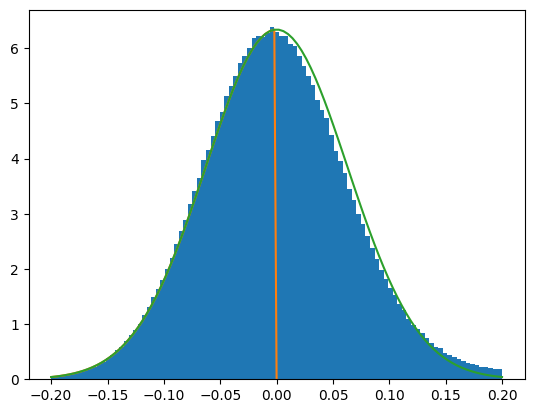

100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


In [16]:
np.random.seed(1)

N_central_pixels = 26
RSP_background_noise_cutoffs = {}
for h5_file_i in tqdm(glob.glob('/mnt/users/hollowayp/paltas/RSP_Coadd_Files_100000/*image*.h5')[0:1]):
    h5_index = h5_file_i.split('/')[-1].split('_')[0]
    h5 = load_h5_file(h5_file_i)
    X_plot = np.linspace(0.2,0,100)
    X_plot_full = np.linspace(-0.2,0.2,100)
    neg_h5 = -h5.flatten()[h5.flatten()<0]
    #Fitting a half-norm distribution to the DP0 coadds (so noise calculation isn't affected by bright objects)
    halfnorm0,halfnorm1 = halfnorm.fit(neg_h5)
    pl.hist((h5.flatten()),density=True,bins=np.linspace(-0.2,0.2,100))
    pl.plot(-X_plot,0.5*halfnorm.pdf(X_plot,halfnorm0,halfnorm1))
    pl.plot(X_plot_full,norm.pdf(X_plot_full,halfnorm0,halfnorm1))
    pl.show()
    # print(halfnorm0,halfnorm1)
    rand_norm_array = norm(halfnorm0,halfnorm1).rvs(size=(N_central_pixels,N_central_pixels,10000)).sum(axis=0).sum(axis=0)
    #Exclude cutout if there the central pixels have sum at least 2-sigma higher than expected from the noise.
    RSP_background_noise_cutoffs[int(h5_index)] = np.mean(rand_norm_array)+2*np.std(rand_norm_array)

RSP_background_noise_cutoffs['N_central_pixels'] = N_central_pixels
# with open('/mnt/users/hollowayp/paltas/RSP_Coadd_Files_100000/Noise_dict.json', "w") as f: 
#     json.dump(RSP_background_noise_cutoffs, f)


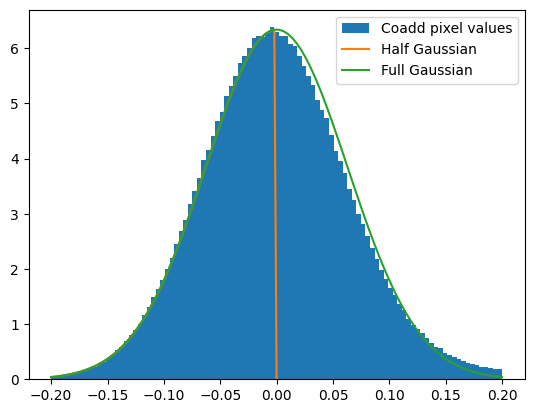

3.243467274422108

In [17]:
measure_noise_level_in_RSP_coadd(h5,N_central_pixels,plot=True)

In [14]:
RSP_background_noise_cutoffs

{85: 3.243467274422108, 'N_central_pixels': 26}

### Plotting which pass/fail the SNR Cut:

In [ ]:
N_cols = 11;N_images = 5*N_cols
N_fail=0;N_pass=0
h5_to_plot = 1 #Index to plot
h5_array = load_h5_file(f'/mnt/users/hollowayp/paltas/RSP_Coadd_Files_100000/{h5_to_plot}_image_data.h5')
central_pixel = h5_array.shape[1]//2
fig,ax = pl.subplots(2,N_cols,figsize=(20,5))
for n_im in range(N_images):
    image_i = h5_array[n_im,:,:]
    if np.sum(image_i[
                central_pixel-(N_central_pixels//2):central_pixel+(N_central_pixels//2),
                central_pixel-(N_central_pixels//2):central_pixel+(N_central_pixels//2)])>RSP_background_noise_cutoffs[h5_to_plot]:
        y=1
        if N_fail<N_cols:
            ax[y,N_fail].imshow(image_i,vmin=-0.1,vmax=0.05*RSP_background_noise_cutoffs[h5_to_plot])
            ax[y,N_fail].set_xticks([])
            ax[y,N_fail].set_yticks([])
        N_fail+=1
    else: 
        y=0
        if N_pass<N_cols:
            ax[y,N_pass].imshow(image_i,vmin=-0.1,vmax=0.05*RSP_background_noise_cutoffs[h5_to_plot])
            ax[y,N_pass].set_xticks([])
            ax[y,N_pass].set_yticks([])
        N_pass+=1
    if N_pass==N_fail and N_pass==N_cols: break
for i in range(2):
    for j in range(N_cols):
        p_start = (h5_array.shape[1]-N_central_pixels)//2
        p_end = (h5_array.shape[1]+N_central_pixels)//2
        ax[i,j].plot([p_start,p_end],[p_end,p_end],c='white')
        ax[i,j].plot([p_start,p_end],[p_start,p_start],c='white')
        ax[i,j].plot([p_start,p_start],[p_start,p_end],c='white')
        ax[i,j].plot([p_end,p_end],[p_start,p_end],c='white')

ax[0,N_cols//2].set_title('Pass Cut',fontsize=18)
ax[1,N_cols//2].set_title('Fail Cut',fontsize=18)
pl.suptitle('Applying $2\sigma$ RSP-Background noise cut',fontweight='bold',fontsize=21)
pl.tight_layout()
pl.show()


### Generating Paltas Config File

In [6]:
try: del db_LensPop_LSST
except: pass
#If I don't want to use the original LensPop output files directly from GitHub, but rather my 
#DP0-suited output files from LensPop code I have run myself, I should run this instead:
db_LensPop_LSST = LensPop_output_dict['DP0'] #pd.read_csv(lenspop_output_catalogue('DP0'))
print('Using DP0-Adapted LensPop Instead. Note: db_LensPop_LSST has been re-defined to be this database')
print('... This does not affect db_LensPop_Euclid.')
#This adapted db was developed here:
#/mnt/users/hollowayp/LensPop_Versions/Compare_LensPop_Populations.ipynb

Using DP0-Adapted LensPop Instead. Note: db_LensPop_LSST has been re-defined to be this database
... This does not affect db_LensPop_Euclid.


In [7]:
Lenspop_db_to_config_format_dict = {'zL':['main_deflector*parameters*z_lens','lens_light*parameters*z_source'],
                            'tE':'main_deflector*parameters*theta_E',
                            'defl_mass_x':'main_deflector*parameters*center_x',#
                            'defl_mass_y':'main_deflector*parameters*center_y',#
                            'defl_gamma':'main_deflector*parameters*gamma',#
                            'defl_e1_mass':'main_deflector*parameters*e1',#
                            'defl_e2_mass':'main_deflector*parameters*e2',#
                            'defl_gamma1':'main_deflector*parameters*gamma1',#
                            'defl_gamma2':'main_deflector*parameters*gamma2',#
                            'i_lens':'lens_light*parameters*mag_app',#For LSST
                            'VIS_lens':'lens_light*parameters*mag_app',#For Euclid
                            'Re_lens':'lens_light*parameters*R_sersic',
                            'defl_Ns':'lens_light*parameters*n_sersic',#
                            'defl_e1_light':'lens_light*parameters*e1',#
                            'defl_e2_light':'lens_light*parameters*e2',#
                            'defl_light_x':'lens_light*parameters*center_x',#
                            'defl_light_y':'lens_light*parameters*center_y',#
                            'zS':'source*parameters*z_source',
                            'i_source':'source*parameters*mag_app',#For LSST
                            'VIS_source':'source*parameters*mag_app',#For Euclid
                            'Re_source':'source*parameters*R_sersic',
                            'source_Ns':'source*parameters*n_sersic',#
                            'xs':'source*parameters*center_x',
                            'ys':'source*parameters*center_y',
                            'e1_source':'source*parameters*e1',
                            'e2_source':'source*parameters*e2'}

Lenspop_to_config_trunc_dict = {'zL':[True,True],
                            'tE':True,
                            'defl_mass_x':False,
                            'defl_mass_y':False,
                            'defl_gamma':True,
                            'defl_e1_mass':False,
                            'defl_e2_mass':False,
                            'defl_gamma1':False,
                            'defl_gamma2':False,
                            'i_lens':False,#For LSST
                            'VIS_lens':False,#For Euclid
                            'Re_lens':True,
                            'defl_Ns':True,
                            'defl_e1_light':False,
                            'defl_e2_light':False,
                            'defl_light_x':False,
                            'defl_light_y':False,
                            'zS':True,
                            'i_source':False,#For LSST
                            'VIS_source':False,#For Euclid
                            'Re_source':True,
                            'source_Ns':True,
                            'xs':False,
                            'ys':False,
                            'e1_source':False,
                            'e2_source':False}
print('Need to revisit this section - have arbitrarily fixed some values')

for db_LensPop_i in [db_LensPop_LSST]:#,db_LensPop_Euclid]:
    #Setting various properties to fixed values - need to come back to this later:
    db_LensPop_i['defl_mass_x']=0 #Assert lens is centered
    db_LensPop_i['defl_mass_y']=0
    db_LensPop_i['defl_light_x']=0
    db_LensPop_i['defl_light_y']=0
    db_LensPop_i['defl_gamma']=2 #Assert SIS profile
    db_LensPop_i['defl_e1_mass']=db_LensPop_i['e1_lens'] #Assert lens light ellipticity follows the mass
    db_LensPop_i['defl_e2_mass']=db_LensPop_i['e2_lens']
    db_LensPop_i['defl_e1_light']=db_LensPop_i['e1_lens']
    db_LensPop_i['defl_e2_light']=db_LensPop_i['e2_lens']
    db_LensPop_i['defl_gamma1']=0 #Assert no shear
    db_LensPop_i['defl_gamma2']=0
    db_LensPop_i['defl_Ns']=4 #Assert lens sersic index = 4
    db_LensPop_i['source_Ns']=1 #Assert source sersic index = 1
    db_LensPop_describe_i = db_LensPop_i.describe()
    db_LensPop_describe_i.loc['sigma_to_zero'] = db_LensPop_describe_i.loc['mean']/db_LensPop_describe_i.loc['std']

db_LensPop_LSST.to_csv(individual_galaxy_catalogue('LSST'))
# db_LensPop_Euclid.to_csv(individual_galaxy_catalogue('Euclid'))


Need to revisit this section - have arbitrarily fixed some values


In [14]:
individual_galaxy_catalogue('LSST')

'/mnt/zfsusers/hollowayp/paltas/datasets/LensPop_databases/LensPop_LSST_Paltas_Catalogue_0.csv'

In [8]:
for survey in ['LSST']:#,'Euclid_VIS']:
    db_LensPop_i = {'LSST':db_LensPop_LSST,
                    #'Euclid_VIS':db_LensPop_Euclid
                    }[survey]
    LP_list_of_means=[]
    LP_list_of_std=[]
    LP_list_of_sigma_to_zero=[]
    LP_list_of_trunc_bool=[]
    LP_list_of_properties=[]
    for prop_i in Lenspop_db_to_config_format_dict.keys():
        if (prop_i in ['i_lens','i_source']) and (survey=='Euclid_VIS'): continue
        if (prop_i in ['VIS_lens','VIS_source']) and (survey=='LSST'):continue
        if isinstance(Lenspop_db_to_config_format_dict[prop_i],list):
            LP_list_of_properties.extend(Lenspop_db_to_config_format_dict[prop_i])
            LP_list_of_trunc_bool.extend(Lenspop_to_config_trunc_dict[prop_i])
            N_add=2
        else:
            LP_list_of_properties.append(Lenspop_db_to_config_format_dict[prop_i])
            LP_list_of_trunc_bool.append(Lenspop_to_config_trunc_dict[prop_i])
            N_add=1
        for i in range(N_add):
            mean_i = np.mean(db_LensPop_i[prop_i])
            std_i = np.std(db_LensPop_i[prop_i])
            LP_list_of_means.append(mean_i)
            LP_list_of_std.append(std_i)
            if ~np.isnan(mean_i/std_i): 
                LP_list_of_sigma_to_zero.append(-mean_i/std_i)
            else: LP_list_of_sigma_to_zero.append(0)
    Lenspop_Config_db = pd.DataFrame({'prop':LP_list_of_properties,
                                    'mean':LP_list_of_means,
                                    'std':LP_list_of_std,
                                    'std1p5':1.5*np.array(LP_list_of_std),
                                    'sigma_to_zero':LP_list_of_sigma_to_zero,
                                    'sigma1p5_to_zero':np.array(LP_list_of_sigma_to_zero)/1.5,
                                    'std1p5':1.5*np.array(LP_list_of_std),
                                    'trunc_bool':LP_list_of_trunc_bool
                                    })
    if survey=='LSST':Lenspop_Config_db.to_csv(population_galaxy_catalogue(survey))
    if survey=='Euclid_VIS': Lenspop_Config_db.to_csv(population_galaxy_catalogue('Euclid'))

Saving to /mnt/zfsusers/hollowayp/sim-pipeline/paltas_databases/Lenspop_LSST_config_db.csv


/tmp/ipykernel_2791418/3469244366.py:26: RuntimeWarning: invalid value encountered in scalar divide
  if ~np.isnan(mean_i/std_i):
/tmp/ipykernel_2791418/3469244366.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  if ~np.isnan(mean_i/std_i):
/tmp/ipykernel_2791418/3469244366.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  LP_list_of_sigma_to_zero.append(-mean_i/std_i)


In [50]:
def code_to_check_configs(survey,catalogue):
    if catalogue: 
        parent_config_file = f'{folder_path}/config_{survey}_Lenspop.py'
        RSP_config_file = f'{folder_path}/config_{survey}_Lenspop_no_RSP.py'
        subtr_config_file = f'{folder_path}/config_{survey}_Lenspop_no_subtr.py'
    else:
        parent_config_file = f'{folder_path}/config_LensPop_catalogue.py'
        RSP_config_file = f'{folder_path}/config_LensPop_catalogue_no_RSP.py'
        subtr_config_file = f'{folder_path}/config_LensPop_catalogue_no_subtr.py'
    for l_0,line_0 in enumerate(open(parent_config_file,'r')):
        for l_1,line_1 in enumerate(open(RSP_config_file,'r')):
            if l_0!=l_1: continue #Only compare entries on the same line
            if len(line_0)>1 and len(line_1)>1:
                try:
                    if line_0[0]!='#': line_0=line_0.split('#')[0].replace('\n','')
                    if line_1[0]!='#': line_1=line_1.split('#')[0].replace('\n','')
                except: line_0.replace('\n','');line_1.replace('\n','')
            #Checking the config files are identical apart from gain, read_noise, sky-brightness, num_exp.
            #(Background noise should always be None anyway, and exp_time is 30s regardless of whether using DP0 or not)
            if line_0 in ["'exposure_time':30,'sky_brightness':100, "]: assert "exposure_time':30" in line_0 and "'exposure_time':30" in line_1
            if line_0 in ["'num_exposures':None,'background_noise':None"]:assert "background_noise':None" in line_0 and "background_noise':None" in line_1
            if line_0 in ['add_RSP_background=True',
                        'assert add_RSP_background==True',
                        "'pixel_scale':0.2,'ccd_gain':0.7,'read_noise':0, ",
                        "'exposure_time':30,'sky_brightness':100, ",
                        "'num_exposures':None,'background_noise':None"]: continue
            if l_0==l_1:assert line_0==line_1
    for l_0,line_0 in enumerate(open(parent_config_file,'r')):
        for l_1,line_1 in enumerate(open(subtr_config_file,'r')):
            if l_0!=l_1: continue #Only compare entries on the same line  
            if line_0 !="'lens_subtraction':True,\n": assert line_0==line_1  

In [51]:
import numpy as np
from importlib import reload
reload(sys.modules['generate_config_file_functions'])
from generate_config_file_functions import generate_config_file,generate_config_file_based_on_database

In [52]:
#Have now changed this LSST file to be the DP0 config (from rerunning LensPop):
LensPop_LSST_config_db = pd.read_csv(population_galaxy_catalogue('LSST'))
#LensPop_Euclid_VIS_config_db = pd.read_csv(population_galaxy_catalogue('Euclid'))

print('SETTING POWER-LAW SLOPE TO 2, WITH LARGE SCATTER OF 0.22 - derived myself - '+\
      'see SL2S_SLACS_Lens_Properties_Notebook.ipynb')

gamma_mean = 2;gamma_sigma = 0.22

for survey in ['LSST']:#,'Euclid_VIS']:
    LensPop_db_i = {'LSST':LensPop_LSST_config_db,
                    #'Euclid_VIS':LensPop_Euclid_VIS_config_db
                    }[survey]
    LensPop_db_i.loc[LensPop_db_i.prop == 'main_deflector*parameters*gamma','mean'] = gamma_mean
    LensPop_db_i.loc[LensPop_db_i.prop == 'main_deflector*parameters*gamma','std'] = gamma_sigma
    LensPop_db_i.loc[LensPop_db_i.prop == 'main_deflector*parameters*gamma','sigma_to_zero'] = gamma_mean/gamma_sigma #Truncating at gamma=1 and gamma=3 (both unphysical)
    LensPop_db_i.loc[LensPop_db_i.prop == 'main_deflector*parameters*gamma','trunc_bool'] = True
    LensPop_db_i.loc[LensPop_db_i.prop == 'main_deflector*parameters*gamma','std1p5'] = 1.5*gamma_sigma
    LensPop_db_i.loc[LensPop_db_i.prop == 'main_deflector*parameters*gamma','sigma1p5_to_zero'] = -1/(1.5*gamma_sigma)
    '''
    Mean of (X^2+Y^2) where X,Y are two gaussian variables with sigma=0.065 is ~0.08. 
    Mean + 2*sigma is ~ 0.17. This is tuned to the result of Wong 2011: https://iopscience.iop.org/article/10.1088/0004-637X/726/2/84/pdf
    '''
    shear_mean = 0;shear_sigma = 0.065 
    for gamma_i in ['gamma1','gamma2']:
        LensPop_db_i.loc[LensPop_db_i.prop == f'main_deflector*parameters*{gamma_i}','mean'] = shear_mean
        LensPop_db_i.loc[LensPop_db_i.prop == f'main_deflector*parameters*{gamma_i}','std'] = shear_sigma
        LensPop_db_i.loc[LensPop_db_i.prop == f'main_deflector*parameters*{gamma_i}','std1p5'] = 1.5*shear_sigma
        LensPop_db_i.loc[LensPop_db_i.prop == f'main_deflector*parameters*{gamma_i}','trunc_bool'] = False
    #
    center_mean = 0;center_sigma = 0.1
    for center_i in ['center_x','center_y']:
      for source_i in ['lens_light','main_deflector']:
        LensPop_db_i.loc[LensPop_db_i.prop == f'{source_i}*parameters*{center_i}','mean'] = center_mean
        LensPop_db_i.loc[LensPop_db_i.prop == f'{source_i}*parameters*{center_i}','std'] = center_sigma
        LensPop_db_i.loc[LensPop_db_i.prop == f'{source_i}*parameters*{center_i}','std1p5'] = 1.5*center_sigma
        LensPop_db_i.loc[LensPop_db_i.prop == f'{source_i}*parameters*{center_i}','trunc_bool'] = False
    #Rounding, to keep things neat:
    LensPop_db_i = np.round(LensPop_db_i,4)
    #DO NOT REMOVE:
    #Ensure the truncations are either negative or the gaussian functions aren't truncated:
    assert (np.array(LensPop_db_i['sigma1p5_to_zero']<=0) | np.array(LensPop_db_i['trunc_bool']==False)).all()

    generate_config_dict = {'list_of_properties':list(LensPop_db_i['prop']),
                            'list_of_means': list(LensPop_db_i['mean']),
                            'list_of_std':list(LensPop_db_i['std1p5']),
                            'list_of_sigma_to_zero': list(LensPop_db_i['sigma1p5_to_zero']),
                            'list_of_truc_bool':list(LensPop_db_i['trunc_bool']),
                            'add_crossmatch':True}
    folder_path = '/mnt/zfsusers/hollowayp/paltas/paltas/Configs/Examples'
    generate_config_file_based_on_database(**generate_config_dict,
        old_config_file_path = f'{folder_path}/config_{survey}.py',
        new_config_file_path = f'{folder_path}/config_{survey}_Lenspop.py')
    if survey=='LSST':
        generate_config_file_based_on_database(**generate_config_dict,
        old_config_file_path = f'{folder_path}/config_{survey}_no_RSP.py',
        new_config_file_path = f'{folder_path}/config_{survey}_Lenspop_no_RSP.py')
        generate_config_file_based_on_database(**generate_config_dict,
        old_config_file_path = f'{folder_path}/config_{survey}_no_subtr.py',
        new_config_file_path = f'{folder_path}/config_{survey}_Lenspop_no_subtr.py')

#Code to check configs are the same across lens–subtracted/with-RSP/original LSST config files: 
#Note this does NOT check the configs are the same across catalogue=True and catalogue=False files:
code_to_check_configs('LSST',catalogue=True)
code_to_check_configs('LSST',catalogue=False)

Saving to /mnt/zfsusers/hollowayp/sim-pipeline/paltas_databases/Lenspop_LSST_config_db.csv
SETTING POWER-LAW SLOPE TO 2, WITH LARGE SCATTER OF 0.22 - derived myself - see SL2S_SLACS_Lens_Properties_Notebook.ipynb
{'main_deflector': {'parameters': {'z_lens': 'truncnorm(-1.1881,np.inf,loc=0.421,scale=0.3544).rvs', 'theta_E': 'truncnorm(-2.6075,np.inf,loc=1.5407,scale=0.5909).rvs', 'center_x': 'norm(loc=0.0,scale=0.15).rvs', 'center_y': 'norm(loc=0.0,scale=0.15).rvs', 'gamma': 'truncnorm(-3.0303,np.inf,loc=2.0,scale=0.33).rvs', 'e1': 'norm(loc=0.0194,scale=0.2039).rvs', 'e2': 'norm(loc=0.0012,scale=0.2084).rvs', 'gamma1': 'norm(loc=0.0,scale=0.0975).rvs', 'gamma2': 'norm(loc=0.0,scale=0.0975).rvs'}}, 'lens_light': {'parameters': {'z_source': 'truncnorm(-1.1881,np.inf,loc=0.421,scale=0.3544).rvs', 'mag_app': 'norm(loc=17.5732,scale=2.7737).rvs', 'output_ab_zeropoint': None, 'R_sersic': 'truncnorm(-0.9474,np.inf,loc=1.144,scale=1.2076).rvs', 'n_sersic': 4.0, 'e1': 'norm(loc=0.0194,scale=0.2